<a href="https://colab.research.google.com/github/chang-heekim/Implementation_Deep_Learning_Paper/blob/main/Generative%20Adversarial%20Networks/GAN_for_MNIST_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [ ]:
import os, time  
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import Model

# Set up hyper parameters & Load MNist dataset

In [ ]:
latent_dim = 100
batch_size = 256
epochs = 500

In [ ]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1).astype('float32')

train_x = (train_x - 127.5) / 127.5
test_x = (test_x  - 127.5) / 127.5
print("train_x.shape = {}".format(train_x.shape))
print("test_x.shape = {}".format(test_x.shape))

train_x.shape = (60000, 28, 28, 1)
test_x.shape = (10000, 28, 28, 1)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(1024).batch(batch_size, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(batch_size, drop_remainder=True)

# Define Generator & Discriminator

In [ ]:
def generator():
    inputs = Input((latent_dim,))

    x = Dense(128, use_bias=False)(inputs)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(256, use_bias=False)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(512, use_bias=False)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(1024, use_bias=False)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(28*28, activation='tanh')(x)
    out = Reshape((28, 28, 1))(x)

    model = Model(inputs, out, name='Generator')
    return model

def discriminator():
    inputs = Input((28, 28, 1))

    x = Flatten()(inputs)
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, out, name='Discriminator')
    return model

In [ ]:
generator = generator()
discriminator = discriminator()

loss_fn = tf.keras.losses.BinaryCrossentropy()

g_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Define Train Function

In [ ]:
@tf.function
def train_step(epoch, images, loss_fn, g_optimizer, d_optimizer):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        z = tf.random.normal([batch_size, latent_dim], 0, 1)
        g_images = generator(z, training=True)

        real_out = discriminator(images)
        fake_out = discriminator(g_images)

        g_loss = loss_fn(tf.ones_like(fake_out), fake_out)

        real_loss = loss_fn(tf.ones_like(real_out), real_out)
        fake_loss = loss_fn(tf.zeros_like(fake_out), fake_out)

        d_loss = (real_loss + fake_loss) / 2

    g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    return g_loss, d_loss

# Training

In [ ]:
for epoch in range(1, 1 + epochs):
    for images, _ in train_dataset:
        g_loss, d_loss = train_step(epoch, images, loss_fn, g_optimizer, d_optimizer)
    print(f'[Epoch {epoch} / {epochs}], G Loss: {g_loss}, D Loss: {d_loss}')

[Epoch 1 / 500], G Loss: 0.8253350257873535, D Loss: 0.6052611470222473
[Epoch 2 / 500], G Loss: 0.9208213090896606, D Loss: 0.5618720054626465
[Epoch 3 / 500], G Loss: 0.5603691935539246, D Loss: 0.627212643623352
[Epoch 4 / 500], G Loss: 0.6465646028518677, D Loss: 0.6001654863357544
[Epoch 5 / 500], G Loss: 1.1401996612548828, D Loss: 0.5563600063323975
[Epoch 6 / 500], G Loss: 0.9425413608551025, D Loss: 0.5642002820968628
[Epoch 7 / 500], G Loss: 0.8560358285903931, D Loss: 0.5433155298233032
[Epoch 8 / 500], G Loss: 0.6848170757293701, D Loss: 0.5863988399505615
[Epoch 9 / 500], G Loss: 0.2654040455818176, D Loss: 0.8312289118766785
[Epoch 10 / 500], G Loss: 0.8192702531814575, D Loss: 0.5307362079620361
[Epoch 11 / 500], G Loss: 1.020681381225586, D Loss: 0.5286600589752197
[Epoch 12 / 500], G Loss: 0.9391814470291138, D Loss: 0.5690574049949646
[Epoch 13 / 500], G Loss: 0.9812250137329102, D Loss: 0.5457456111907959
[Epoch 14 / 500], G Loss: 0.7231684327125549, D Loss: 0.592482

# Visualization Generated Images

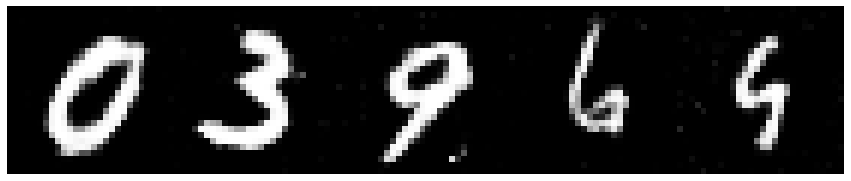

In [ ]:
z = tf.random.normal([5, 100])

generated_imgs = generator.predict(z)
generated_imgs = generated_imgs.transpose((1, 0, 2, 3)).reshape(28, -1)

plt.figure(figsize=(15, 4))
plt.imshow(generated_imgs, 'gray')
plt.axis('off')
plt.show()